# SMT Solver for VLSI

In [1]:
from itertools import combinations
from z3 import *
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import time

In [2]:
def plot_result(dims, w, ys, xs):
    lims = (0, max(w, max([ys[i]+dims[i][1] for i in range(len(ys))])))

    fig1 = plt.figure(figsize=(10, 10))
    ax1 = fig1.add_subplot(111, aspect='equal')
    for i in range(len(xs)):
        ax1.add_patch(patches.Rectangle((xs[i], ys[i]), dims[i][0], dims[i][1], edgecolor='black', facecolor=random.choice(['r', 'g', 'y'])))

    plt.xticks(range(w+1))
    plt.yticks(range(max([ys[i]+dims[i][1] for i in range(len(ys))])+1))
    #plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.show()

In [3]:
def max_z3(vars):
    max = vars[0]
    for v in vars[1:]:
        max = If(v > max, v, max)
    return max

In [4]:
def read_instance(instance_id):
    filepath = "../instances/ins-" + str(instance_id) + ".txt"
    with open(filepath, "r") as f_in:
        f = f_in.readlines()
        for i in range(len(f)):
            if not f[i][-1].isnumeric():
                f[i] = f[i][:-1]
                
        W = int(f[0])
        n = int(f[1])
        dims_line = f[2].split(" ")    
        dims = [[int(dims_line[0]), int(dims_line[1])]]
        for i in range(1, int(f[1])-1):
            dims_line = f[2 + i].split(" ")
            dims.append([int(dims_line[0]), int(dims_line[1])])
        dims_line = f[-1].split(" ")
        dims.append([int(dims_line[0]), int(dims_line[1])])
        
        dims = sorted(dims, key=lambda l:l[0]*l[1], reverse=True)
        
    return dims, W, n

In [32]:
def alphaMEncoding(opt, A, B):
    n = len(A)
    print(A)
    print(B)
    alphas = [Bool("a_%s" % (i)) for i in range(n+1)]
    opt.add(alphas[0] == True)
    T1 = [Bool("t1_%s" % (i)) for i in range(n)]
    T2 = [Bool("t2_%s" % (i)) for i in range(n)]
    T3 = [Bool("t3_%s" % (i)) for i in range(n)]
    for i in range(n):
        opt.add(Implies(T1[i], A[i] <= B[i]))
        opt.add(Implies(A[i] <= B[i], T1[i]))
        opt.add(Implies(T2[i], A[i] < B[i]))
        opt.add(Implies(A[i] < B[i], T2[i]))
        opt.add(Implies(T3[i], Or(T2[i], alphas[i+1])))
        opt.add(Implies(Or(T2[i], alphas[i+1]), T3[i]))
        opt.add(Implies(alphas[i], And(T3[i], T1[i])))
        opt.add(Implies(And(T3[i], T1[i]), alphas[i]))
    return opt

Solving time (s):  0.00654911994934082


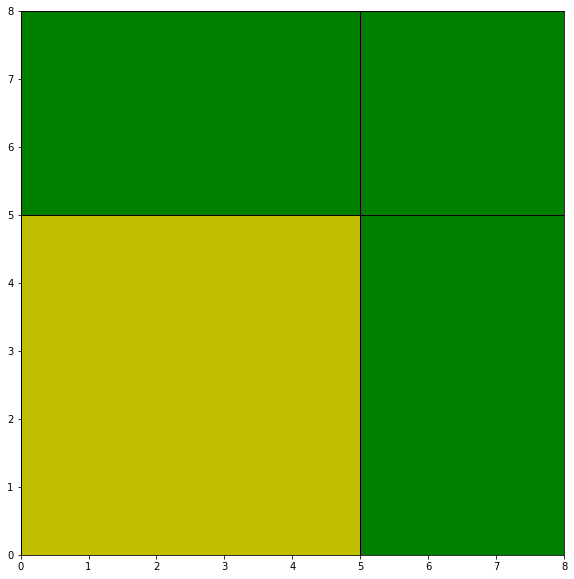

In [90]:
dims, W, n = read_instance(1)
# Solver
opt = Optimize()

sol = [[Int("x_%s" % (i)), Int("y_%s" % (i))] for i in range(n)]

# overlapping
for i in range(n):
    for j in range(n):
        if i != j:
            opt.add(Or(sol[i][0] + dims[i][0] <= sol[j][0],
                       sol[j][0] + dims[j][0] <= sol[i][0],
                       sol[i][1] + dims[i][1] <= sol[j][1],
                       sol[j][1] + dims[j][1] <= sol[i][1]))

# width
for i in range(n):
    opt.add(sol[i][0] + dims[i][0] <= W)
    opt.add(sol[i][0] >= 0) # min
    opt.add(sol[i][0] <= W - min([dims[i][0] for i in range(n)])) # max
    
# height min
for i in range(n):
    opt.add(sol[i][1] >= 0)
    
# Biggest rectangle in (0, 0)
opt.add(And(sol[0][0] ==0, sol[0][1] ==0))

# Symmetry breaking
flags = [False for i in range(n)]
for i in range(n):
    equal_hor = []
    equal_ver = []
    for j in range(n):
        if i<=j and dims[i][0] == dims[j][0] and dims[i][1] == dims[j][1] and not flags[j]:
            equal_hor.append(sol[j][0])
            flags[j] = True
            equal_ver.append(sol[j][1])
            
    if len(equal_hor) > 1:
        opt = alphaMEncoding(opt, equal_hor, [equal_hor[len(equal_hor)-1-k] for k in range(len(equal_hor))])
        opt = alphaMEncoding(opt, equal_ver, [equal_ver[len(equal_ver)-1-k] for k in range(len(equal_ver))])
    
for i in range(n):
    for j in range(n):
        if i<j and dims[i][0] == dims[j][0]:
            opt.add(Implies(sol[i][0]==sol[j][0], sol[i][1]<=sol[j][1]))
        if i<j and dims[i][1] == dims[j][1]:
            opt.add(Implies(sol[i][1]==sol[j][1], sol[i][0]<=sol[j][0]))

height_opt = Int('height_opt')
opt.add(height_opt <= sum([dims[i][1] for i in range(n)])) # upper bound
opt.add(height_opt >= int(sum([dims[i][1]*dims[i][0] for i in range(n)])/W)) # lower bound
objective = height_opt == max_z3([sol[i][1] + dims[i][1] for i in range(n)])
opt.add(objective)
opt.minimize(height_opt)

start_time = time.time()
opt.check()
m = opt.model()
print("Solving time (s): ", time.time()-start_time)

ys = []
xs = []
for i in range(n):
    xs.append(int(m.evaluate(sol[i][0]).as_string()))
    ys.append(int(m.evaluate(sol[i][1]).as_string()))
    
plot_result(dims, W, ys, xs)

In [29]:
sol = Solver()

# Variables

# Agatha, the butler, and Charles live in Dreadsbury Mansion, and are the only ones to live there.
Mansion, (agatha, butler, charles) = EnumSort("Mansion", ["Agatha", "Butler", "Charles"])

# Who hates whom?
hates = Function("hates", Mansion, Mansion, BoolSort())
# Who is richer than whom?
richer = Function("richer", Mansion, Mansion, BoolSort())
# Who killed agatha?
killed = Function("killed", Mansion, Mansion, BoolSort())

# For the logics
x = Const("x", Mansion)
y = Const("y", Mansion)

# constraints

# Who killed Agatha?
sol.add(Exists(x, killed(x, agatha)))

# A killed always hates, and is no richer than his victim. 
sol.add(ForAll([x, y], Implies(killed(x, y), And(hates(x, y), Not(richer(x, y))))))

# Charles hates none that Agatha hates. 
sol.add(ForAll(x, Implies(hates(agatha, x), Not(hates(charles, x)))))

# Agatha hates everybody except the butler.        
sol.add(hates(agatha, agatha), hates(agatha, charles))

# The butler hates everyone not richer than Aunt Agatha. 
sol.add(ForAll(x, Implies(Not(richer(x, agatha)), hates(butler, x))))

# The butler hates everyone whom Agatha hates. 
sol.add(ForAll(x, Implies(hates(agatha, x), hates(butler, x))))

# None hates everyone. 
sol.add(ForAll(x, Exists([y], Not(hates(x, y)))))

sol

[Exists(x, killed(x, Agatha)),
 ForAll([x, y],
        Implies(killed(x, y),
                And(hates(x, y), Not(richer(x, y))))),
 ForAll(x,
        Implies(hates(Agatha, x), Not(hates(Charles, x)))),
 hates(Agatha, Agatha),
 hates(Agatha, Charles),
 ForAll(x,
        Implies(Not(richer(x, Agatha)), hates(Butler, x))),
 ForAll(x, Implies(hates(Agatha, x), hates(Butler, x))),
 ForAll(x, Exists(y, Not(hates(x, y))))]

In [7]:
def rectanglePacking_smt(n, dims, w, h):
    # 
    sol = [[Int("x_%s" % (i)) for i in range(n)], # x
           [Int("y_%s" % (i)) for i in range(n)]] # y

    # 
    diffn = [ForAll]

    # each row contains a digit at most once
    rows_c = [Distinct(v[i]) for i in range(9)]

    # each column contains a digit at most once
    cols_c = [Distinct([v[i][j] for i in range(9)]) for j in range(9)]

    # each 3x3 square contains a digit at most once
    sq_c = [Distinct([v[3 * a + i][3 * b + j] for i in range(3) for j in range(3)])
            for a in range(3) for b in range(3)]

    sudoku_c = cells_c + rows_c + cols_c + sq_c

    instance_c = [If(instance[i][j] == 0, True, v[i][j] == instance[i][j])
                  for i in range(9) for j in range(9)]

    s = Solver()
    s.add(sudoku_c + instance_c)
    
    if s.check() == sat:
        m = s.model()
        return [[int(m.evaluate(v[i][j]).as_string()) for j in range(9)] for i in range(9)]
    else:
        print("Failed to solve")

## Scheduling

In [10]:
def max_z3(vars):
    max = vars[0]
    for v in vars[1:]:
        max = If(v > max, v, max)
    return max

def schedule(jobs):
    # Variables
    t = []
    for i, job in enumerate(jobs):
        t.append([])
        for j, _ in enumerate(job):
            t[i].append(Int(f"t{i}_{j}"))

    # Solver
    opt = Optimize()

    # Starting time of the task >= 0
    for job in t:
        for start_time in job:
            opt.add(start_time >= 0)

    # Precedence among the successive tasks of each job
    for i, job in enumerate(t):
        for j, (prev, succ) in enumerate(zip(job[:-1], job[1:])):
            opt.add(prev + jobs[i][j][1] <= succ)

    # Machines can only execute one task at a time
    machine_ctrs = {}
    for job in jobs:
        for task in job:
            machine_ctrs[task[0]] = []

    all_tasks = [task for i, job in enumerate(jobs) for task in zip(t[i], job)]
    for (t1, task1), (t2, task2) in combinations(all_tasks, 2):
        if task1[0] == task2[0]:
            machine_ctrs[task1[0]].append(Or(t1 + task1[1] <= t2, t2 + task2[1] <= t1))

    for ctrs_list in machine_ctrs.values():
        opt.add(And(ctrs_list))

    # Objective
    last_tasks = [start_list[-1] + job[-1][1] for job, start_list in zip(jobs, t)]
    makespan = Int('makespan')
    opt.add(makespan <= sum([task[1] for job in jobs for task in job])) # upper bound
    objective = makespan == max_z3(last_tasks)
    opt.add(objective)
    opt.minimize(makespan)

    opt.check()
    m = opt.model()
    sol = []
    for i, job in enumerate(jobs):
        for j, task in enumerate(job):
            start_time = int(m.evaluate(t[i][j]).as_string())
            sol.append({
                'job': i,
                'machine': task[0],
                'duration': task[1],
                'start': start_time,
                'finish': start_time + task[1]
            })
    return sol